#### Importing libraries

In [24]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

#### Merged Dataset

In [25]:
# Load the merged dataset
data = pd.read_csv('Final_dataset.csv')

### 1. Calculate Customer's tenure (in days)

In [26]:
# Feature Engineering
data['SignupDate'] = pd.to_datetime(data['SignupDate'], format='%d-%m-%Y')  # Ensure proper format for 'SignupDate'
data['TransactionDate'] = pd.to_datetime(data['TransactionDate'], errors='coerce')  # Handle invalid formats
data['Tenure'] = (pd.to_datetime('today') - data['SignupDate']).dt.days

C:\Users\jofin\AppData\Local\Temp\ipykernel_13012\1400941607.py:3: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data['TransactionDate'] = pd.to_datetime(data['TransactionDate'], errors='coerce')  # Handle invalid formats


### 2. Aggregate transactions by CustomerID

In [27]:
# Ensure 'TotalValue' and 'Quantity' are numeric, convert if necessary
data['TotalValue'] = pd.to_numeric(data['TotalValue'], errors='coerce')
data['Quantity'] = pd.to_numeric(data['Quantity'], errors='coerce')

customer_data = data.groupby('CustomerID').agg(
    total_spent=('TotalValue', 'sum'),
    total_quantity=('Quantity', 'sum'),
    num_transactions=('TransactionID', 'nunique'),
    avg_transaction_value=('TotalValue', 'mean'),
    tenure=('Tenure', 'max')
).reset_index()

# Check for any NaN values after aggregation and handle them
customer_data = customer_data.dropna()

### 3. Normalize the features

In [28]:
features = customer_data[['total_spent', 'total_quantity', 'num_transactions', 'avg_transaction_value', 'tenure']]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

### 4. Determine the optimal number of clusters using Elbow Method

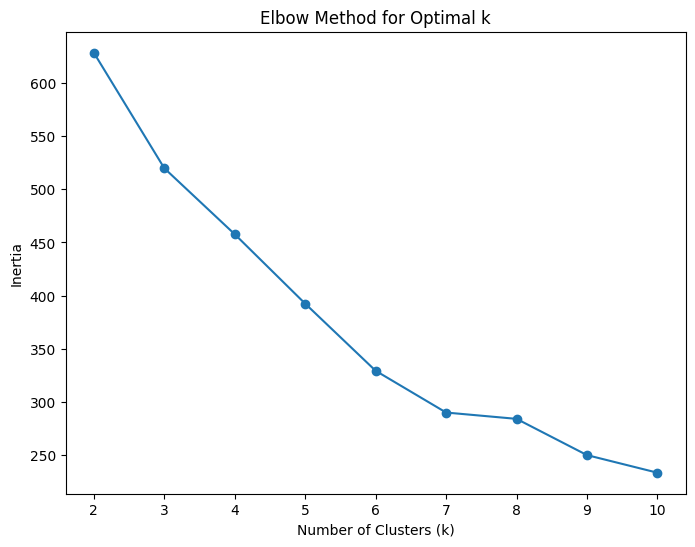

In [29]:
inertia = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(8, 6))
plt.plot(range(2, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.show()

### 5. Fit KMeans with optimal number of clusters (e.g., 5 based on the Elbow plot)

In [30]:
kmeans = KMeans(n_clusters=5, random_state=42)
customer_data['cluster'] = kmeans.fit_predict(scaled_features)

### 6. Calculate clustering metrics (DB Index and Silhouette Score)

In [31]:
db_index = davies_bouldin_score(scaled_features, customer_data['cluster'])
sil_score = silhouette_score(scaled_features, customer_data['cluster'])

# Print clustering metrics
print(f"DB Index: {db_index}")
print(f"Silhouette Score: {sil_score}")

DB Index: 1.2322860190392264
Silhouette Score: 0.23795103000527118


### 7. Visualizing the clusters (2D example)

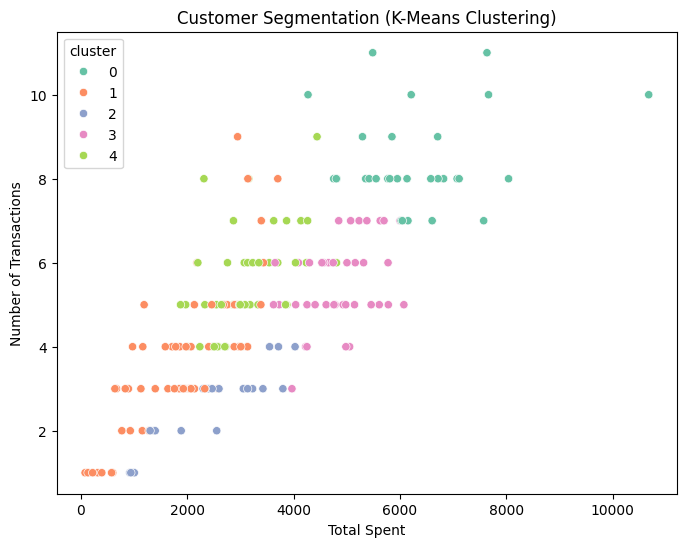

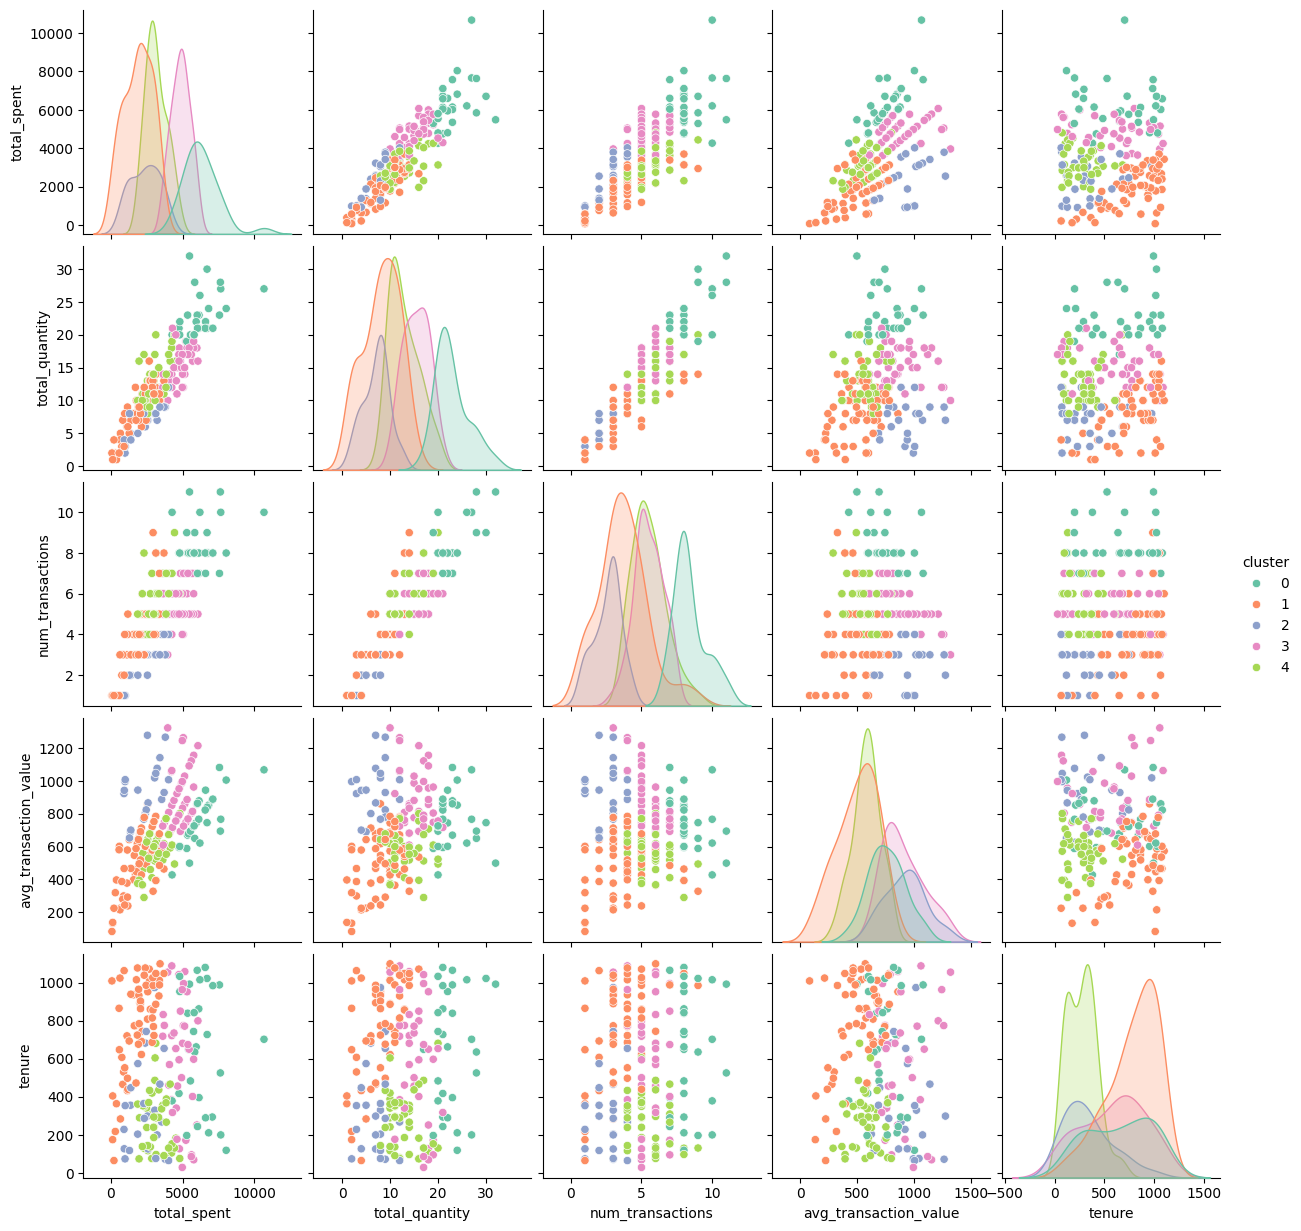

In [32]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=customer_data['total_spent'], y=customer_data['num_transactions'], hue=customer_data['cluster'], palette="Set2")
plt.title('Customer Segmentation (K-Means Clustering)')
plt.xlabel('Total Spent')
plt.ylabel('Number of Transactions')
plt.show()

# Optionally, use pairplot for high-dimensional data visualization
sns.pairplot(customer_data[['total_spent', 'total_quantity', 'num_transactions', 'avg_transaction_value', 'tenure', 'cluster']], hue='cluster', palette="Set2")
plt.show()